### 14-1. 프로젝트: 이제까지 만들었던 모델을 튜닝하고 배포하기!
이번 프로젝트는 여러분들이 배운 프로젝트중에서 CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포하는 미션입니다!

#### 0. 모델 고정해서 사용하기
이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정입니다. 모델의 경우에는 다음과 같은 그림으로 구성해주세요!


- 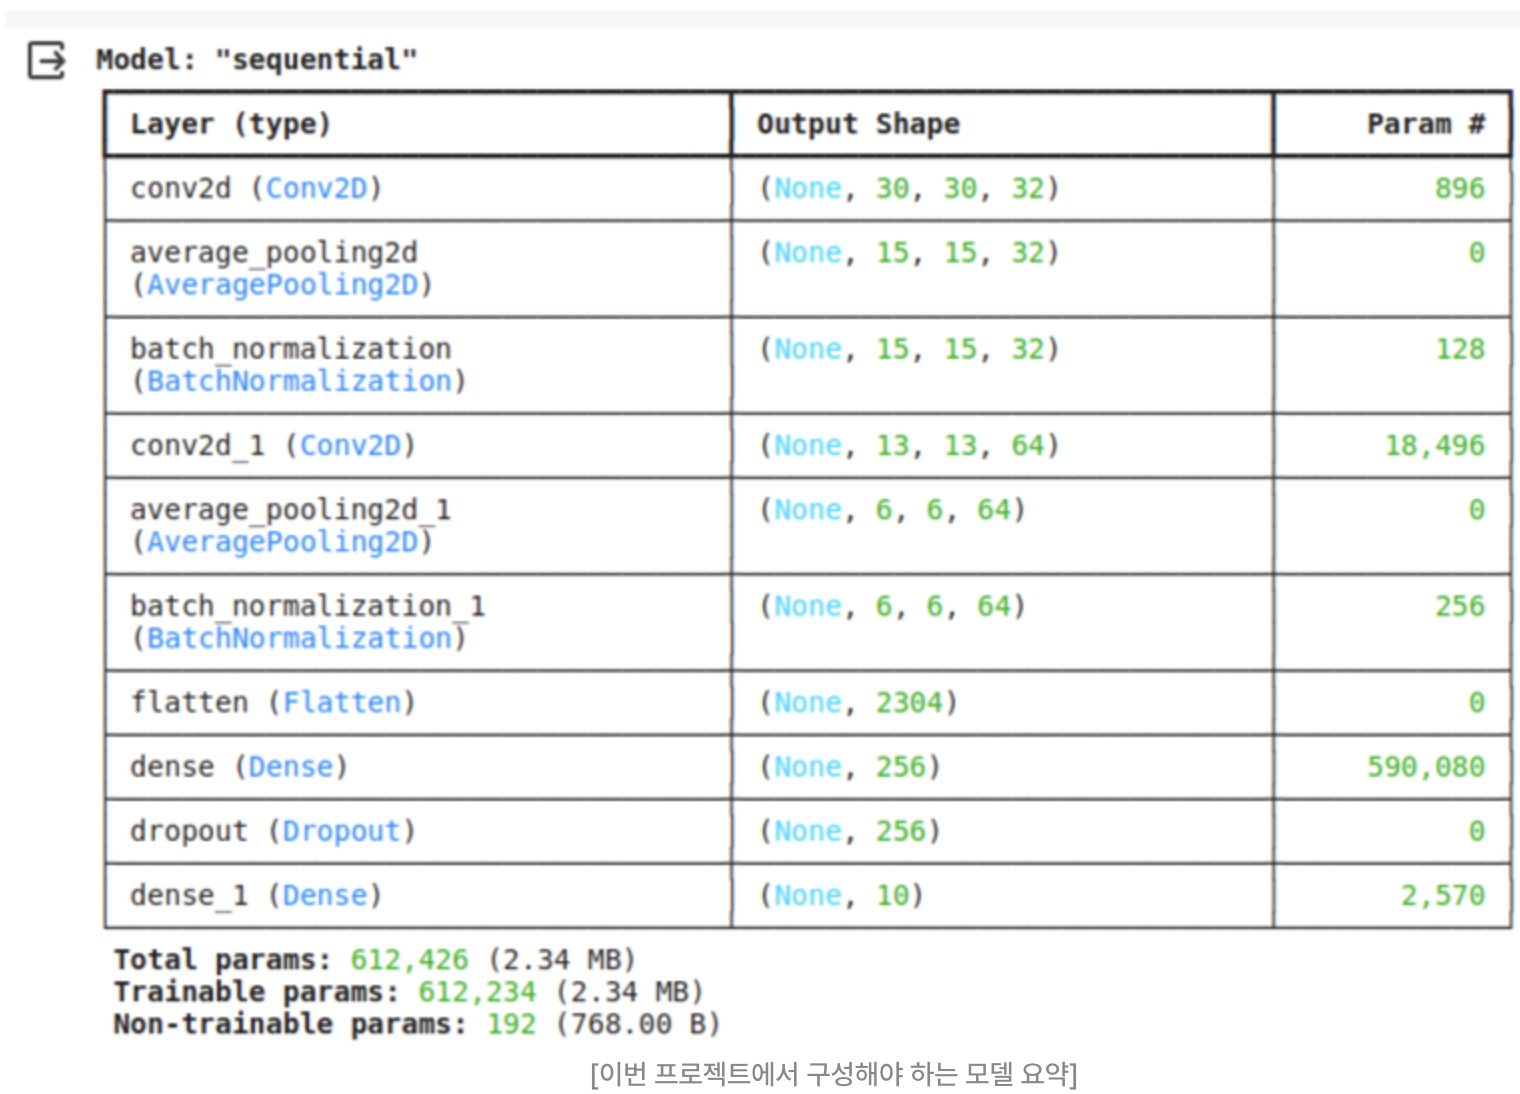
-----
#### 1. Data Centric AI 맛보기
Data Centric AI를 공부했으니 한번 맛은 봐야겠죠? Data Centric AI를 정석적으로 진행한다면 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 합니다.
하지만 우리에게는 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하겠습니다.

labelerrors.com
- https://labelerrors.com/
labelerrors.com은 Data Centric AI에서 가장 많이 활용하고 있는 파이썬 라이브러리인 cleanlab을 만든 개발자들이 공개한 사이트입니다. labelerrors.com은 이름에서 알 수 있듯이 테스트 데이터와 label이 잘못 붙어 있는 사례를 모아 보여줍니다.
labelerrors.com에서 CIFAR10 테스트 데이터셋을 확인하고 아래 조그맣게 있는 ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정해주세요.

-----
#### 2. 하이퍼파라미터 튜닝
위에 있는 모델을 기반으로 KerasTuner로 하이퍼파라미터 튜닝을 진행합니다. 튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장해주세요.

(주의사항)
하이퍼 파라미터를 어느정도 범위로 주는지에 따라서 모델 튜닝속도가 달라집니다.
학습시간을 고려해서 하이퍼 파라미터 튜닝을 세팅해주세요!


-----
### 3. 모델 배포하기 (옵션)
하이퍼파라미터 튜닝을 끝낸 모델을 Docker 혹은 WSL2 환경에서 TFServing을 진행해 모델을 배포하세요! 모델 배포가 성공했다면 해당 코드쉘을 캡쳐해서 이미지를 주피터 노트북에 넣어주세요!

-----

### 4. TFLite 모델 만들기 (옵션)
여러분들이 만든 모델을 TFLite 모델로 만들어서 저장하고 서명을 확인하는 메소드까지 입력해주세요!

-----

### (추가미션) 박찬성님의 TFX 프로젝트 분석해보기
- 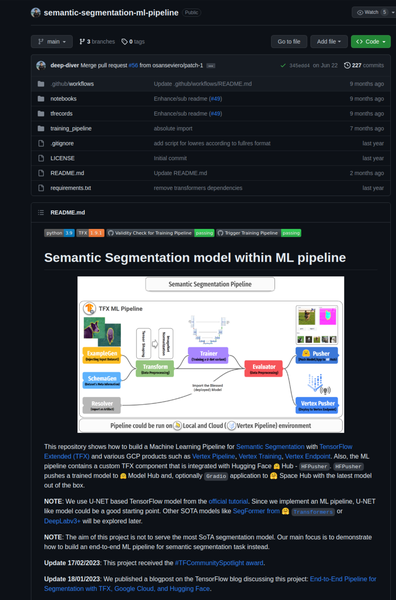
- https://github.com/deep-diver/semantic-segmentation-ml-pipeline

이번 노드에서 TensorFlow Extended에 대한 컴포넌트 소개를 했지만 각각 컴포넌트가 어떻게 작동하는지 코드를 보지 않았습니다.
현재 Machine Learning GDE(Google Developers Expert)이자 Hugging Face Fellow로 활동하고 계신 박찬성님은 전세계적으로 손꼽히는 TFX를 잘 다루는 유저입니다.
위에 올린 깃헙주소의 경우 박찬성님께서 진행한 TFX 프로젝트중 하나로 Semantic Segmentation 모델을 사용한 ML 파이프라인 제작 프로젝트입니다.

해당 프로젝트를 분석한다면 여러분들께서 TFX에 대한 이해도가 높아져서 TFX의 매력에 빠지게 될거라는 생각이 듭니다!

만일 1번부터 3번까지 프로젝트를 다 진행하셨다면 추가미션을 통해 TFX를 이해하는 시간을 가졌으면 좋겠습니다!

In [1]:
# TensorFlow와 CIFAR-10 데이터셋을 가져오는 데 필요한 모듈을 임포트합니다.
import tensorflow as tf
from tensorflow.keras.datasets import cifar10  # CIFAR-10 데이터셋 로드를 위한 모듈
from tensorflow.keras.utils import to_categorical  # 레이블을 원-핫 인코딩하기 위한 유틸리티
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리

# CIFAR-10 데이터셋 로드
# x_train: 학습용 이미지 데이터
# y_train: 학습용 레이블 데이터
# x_test: 테스트용 이미지 데이터
# y_test: 테스트용 레이블 데이터
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 데이터셋의 클래스 이름 정의
# CIFAR-10에는 10개의 클래스가 있으며, 각각 다음과 같습니다:
# 0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer,
# 5: dog, 6: frog, 7: horse, 8: ship, 9: truck
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


In [2]:
def visualize_and_correct_label(wrong_id):
    """
    잘못된 레이블을 확인하고 수정하는 함수입니다.
    
    Args:
        wrong_id (list): 잘못된 레이블 정보가 담긴 리스트.
            각 리스트 요소는 딕셔너리 형식으로, 다음 키를 포함합니다:
                - 'id': 이미지 ID (int)
                - 'answer': 올바른 클래스 이름 (str)
    
    동작:
        1. 잘못 레이블된 이미지를 시각화합니다.
        2. 원래 레이블과 올바른 레이블을 비교합니다.
        3. 레이블이 잘못된 경우 수정합니다.
    """
    for item in wrong_id:  # 잘못된 레이블의 정보를 하나씩 확인
        image_id = item['id']  # 이미지 ID
        correct_answer = item['answer']  # 올바른 클래스 이름
        
        # 1. 이미지를 화면에 출력
        plt.imshow(x_test[image_id])  # 테스트 데이터셋에서 이미지 로드
        plt.title(f"Original Label: {class_names[y_test[image_id][0]]}")  # 현재 레이블 표시
        plt.show()
        
        # 2. 현재 레이블 가져오기
        current_label = class_names[y_test[image_id][0]]  # 현재 레이블 이름
        
        if current_label != correct_answer:  # 레이블이 올바르지 않은 경우
            # 3. 레이블을 올바르게 수정
            y_test[image_id] = class_names.index(correct_answer)  # 올바른 클래스 인덱스로 변경
            print(f"'{correct_answer}'로 변경. ID: {image_id}")  # 변경 사항 출력
        else:
            # 레이블이 이미 올바른 경우
            print(f"{image_id}의 라벨이 이미 '{current_label}'입니다.")  # 알림 메시지 출력


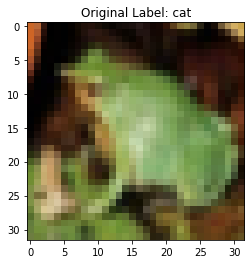

'frog'로 변경. ID: 2405


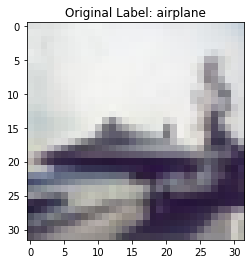

'ship'로 변경. ID: 6877


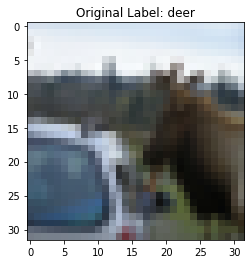

'horse'로 변경. ID: 8058


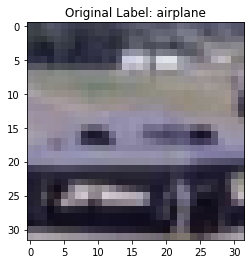

'automobile'로 변경. ID: 2532


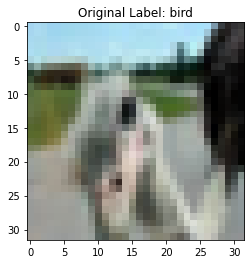

'horse'로 변경. ID: 7657


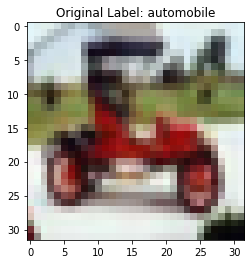

'truck'로 변경. ID: 1969


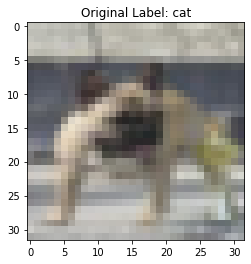

'dog'로 변경. ID: 2804


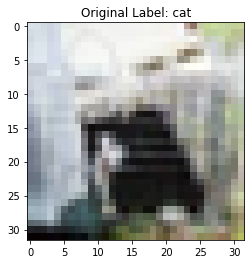

'truck'로 변경. ID: 6792


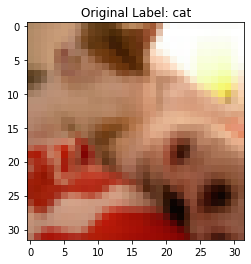

'dog'로 변경. ID: 1227


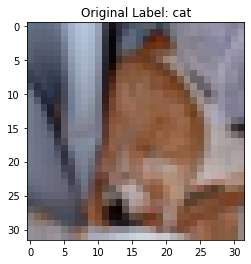

'dog'로 변경. ID: 5191


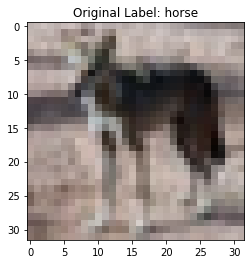

'deer'로 변경. ID: 5690


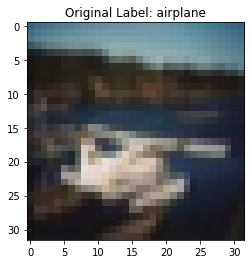

'ship'로 변경. ID: 1718


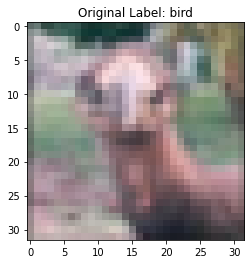

'deer'로 변경. ID: 2592


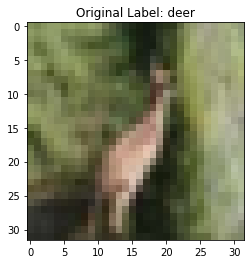

'bird'로 변경. ID: 4794


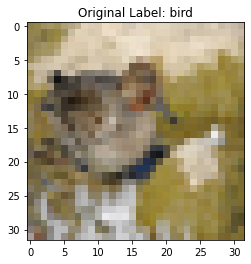

'cat'로 변경. ID: 5960


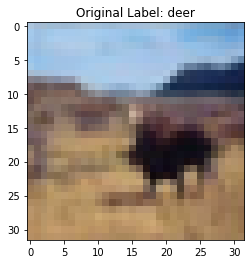

'bird'로 변경. ID: 165


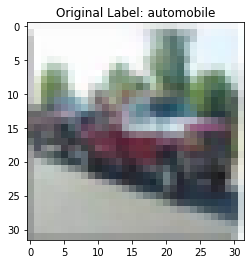

'truck'로 변경. ID: 9227


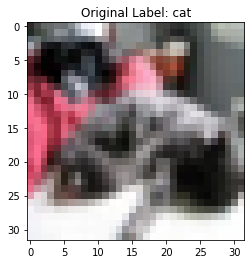

'dog'로 변경. ID: 5632


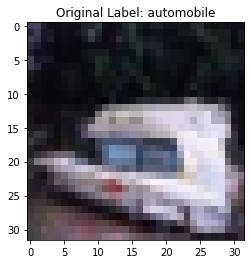

'truck'로 변경. ID: 9352


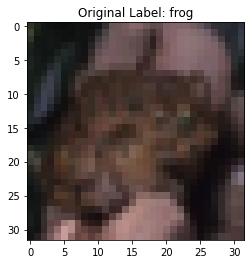

'cat'로 변경. ID: 7846


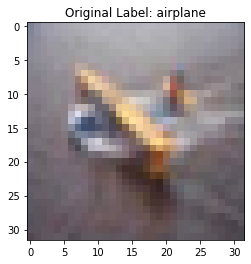

'ship'로 변경. ID: 6966


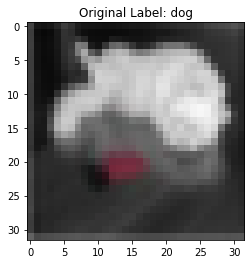

'cat'로 변경. ID: 5468


In [3]:
wrong_id = [
  {'id': 2405, 'answer': 'frog'},
  {'id': 6877, 'answer': 'ship'},
  {'id': 8058, 'answer': 'horse'},
  {'id': 2532, 'answer': 'automobile'},
  {'id': 7657, 'answer': 'horse'},
  {'id': 1969, 'answer': 'truck'},
  {'id': 2804, 'answer': 'dog'},
  {'id': 6792, 'answer': 'truck'},
  {'id': 1227, 'answer': 'dog'},
  {'id': 5191, 'answer': 'dog'},
  {'id': 5690, 'answer': 'deer'},
  {'id': 1718, 'answer': 'ship'},
  {'id': 2592, 'answer': 'deer'},
  {'id': 4794, 'answer': 'bird'},
  {'id': 5960, 'answer': 'cat'},
  {'id': 165, 'answer': 'bird'},
  {'id': 9227, 'answer': 'truck'},
  {'id': 5632, 'answer': 'dog'},
  {'id': 9352, 'answer': 'truck'},
  {'id': 7846, 'answer': 'cat'},
  {'id': 6966, 'answer': 'ship'},
  {'id': 5468, 'answer': 'cat'}
]
visualize_and_correct_label(wrong_id)

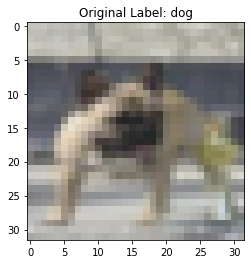

In [4]:
# 테스트 데이터셋에서 특정 이미지를 시각화하고 레이블을 확인합니다.

# 1. 이미지 데이터를 시각화합니다.
# x_test[2804]: 테스트 데이터셋에서 ID 2804에 해당하는 이미지 데이터를 가져옵니다.
plt.imshow(x_test[2804])  # 이미지를 출력합니다.

# 2. 이미지의 원래 레이블을 표시합니다.
# y_test[2804][0]: 테스트 데이터셋에서 ID 2804에 해당하는 이미지의 레이블(정답 클래스)을 가져옵니다.
# class_names: CIFAR-10 클래스 이름 리스트로, 숫자 레이블을 사람이 읽을 수 있는 이름으로 변환합니다.
plt.title(f"Original Label: {class_names[y_test[2804][0]]}")  # 제목에 클래스 이름을 표시합니다.

# 3. 시각화한 이미지를 화면에 출력합니다.
plt.show()  # 이미지와 제목을 출력해 사용자가 확인할 수 있도록 합니다.


In [5]:
# 1. 입력 데이터(x_train, x_test)를 정규화하여 0~1 범위로 스케일 조정
# 원래 CIFAR-10 데이터는 픽셀 값이 0~255의 범위를 가지는 정수형(int) 데이터입니다.
# 신경망 모델의 효율적인 학습을 위해 데이터를 실수형(float32)로 변환하고
# 255로 나눠 0~1 범위의 값으로 정규화합니다.

x_train = x_train.astype('float32') / 255.0  # 학습 데이터 정규화
x_test = x_test.astype('float32') / 255.0  # 테스트 데이터 정규화

# 2. 레이블(y_train, y_test)을 원-핫 인코딩(one-hot encoding) 형식으로 변환
# CIFAR-10의 레이블은 0~9 사이의 정수로 표현되며, 각각 10개의 클래스를 나타냅니다.
# 신경망 출력층에서 크로스 엔트로피 손실 함수를 사용하려면 레이블을 원-핫 인코딩 형식으로 변환해야 합니다.
# 예: 레이블 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# '10'은 CIFAR-10 데이터셋의 클래스 수를 나타냅니다.

y_train = to_categorical(y_train, 10)  # 학습 레이블 원-핫 인코딩
y_test = to_categorical(y_test, 10)  # 테스트 레이블 원-핫 인코딩


In [6]:
!pip install keras-tuner --upgrade

In [7]:
# 필요한 라이브러리 임포트
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout  # 신경망 레이어
from keras_tuner import RandomSearch  # 하이퍼파라미터 튜닝을 위한 RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters  # 하이퍼파라미터 정의를 위한 모듈

# 하이퍼파라미터 기반 모델 생성 함수
def build_model(hp):
    """
    하이퍼파라미터 탐색을 위해 Keras Tuner가 사용할 신경망 모델을 생성합니다.
    
    Args:
        hp (HyperParameters): Keras Tuner에서 제공하는 하이퍼파라미터 객체로,
                              모델의 하이퍼파라미터를 설정하는 데 사용됩니다.
    
    Returns:
        tf.keras.Sequential: 하이퍼파라미터 기반으로 생성된 신경망 모델
    """
    # Sequential API를 사용해 모델 생성
    model = tf.keras.Sequential()

    # 1. 첫 번째 Convolution 레이어
    # Conv2D: 32개의 필터, 크기 (3, 3), ReLU 활성화 함수
    # input_shape: CIFAR-10 데이터셋의 입력 형태 (32, 32, 3)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    
    # 2. AveragePooling 레이어: 다운샘플링을 통해 특징 맵 크기 감소
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # 3. BatchNormalization: 각 배치의 평균과 분산을 정규화하여 훈련 안정화
    model.add(BatchNormalization())

    # 4. 두 번째 Convolution 레이어
    # Conv2D: 64개의 필터, 크기 (3, 3), ReLU 활성화 함수
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    # 5. AveragePooling 및 BatchNormalization
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # 6. Flatten 레이어: 2D 데이터를 1D로 변환하여 Dense 레이어에 전달
    model.add(Flatten())

    # 7. 첫 번째 Dense 레이어
    # units: 하이퍼파라미터로 조정 (128~512, 64 단위로 증가)
    # ReLU 활성화 함수 사용
    model.add(Dense(units=hp.Int('units', min_value=128, max_value=512, step=64), activation='relu'))

    # 8. Dropout 레이어
    # rate: 하이퍼파라미터로 조정 (0.2~0.5, 0.1 단위로 증가)
    # 과적합 방지를 위해 일부 뉴런의 출력을 무작위로 0으로 설정
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # 9. 출력 Dense 레이어
    # 10개의 유닛 (CIFAR-10의 클래스 수와 동일), softmax 활성화 함수 사용
    model.add(Dense(10, activation='softmax'))

    # 모델 컴파일
    # Adam 옵티마이저: 학습률(learning_rate)을 하이퍼파라미터로 조정 (1e-4 ~ 1e-2, 로그 스케일)
    # 손실 함수: Categorical Crossentropy (다중 클래스 분류 문제에 적합)
    # 평가 지표: Accuracy
    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model  # 생성된 모델 반환


In [8]:
# Keras Tuner의 RandomSearch 튜너를 사용하여 모델 하이퍼파라미터를 탐색합니다.
from kerastuner.tuners import RandomSearch  # 랜덤 서치를 위한 모듈 임포트

# RandomSearch 튜너 인스턴스 생성
tuner = RandomSearch(
    build_model,  # 하이퍼파라미터 탐색에 사용할 모델 빌드 함수
    objective='val_accuracy',  # 목표: 검증 데이터셋(val)의 정확도(val_accuracy) 최대화
    max_trials=10,  # 총 10개의 다른 하이퍼파라미터 조합을 시도
    executions_per_trial=2,  # 각 조합을 2번 실행하여 평균 성능 평가
    directory='./best_model/1',  # 탐색 결과를 저장할 디렉터리
    project_name='cifar10_tuning'  # 탐색 프로젝트 이름
)


/tmp/ipykernel_1098/1703722326.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [9]:
# 하이퍼파라미터 탐색을 시작합니다.
tuner.search(
    x_train, y_train,  # 학습 데이터 및 레이블
    epochs=10,  # 각 하이퍼파라미터 조합에 대해 최대 10 에포크 동안 학습
    validation_data=(x_test, y_test),  # 검증 데이터 및 레이블
    batch_size=64  # 배치 크기: 한 번에 64개의 샘플로 모델을 업데이트
)

# 최적의 하이퍼파라미터를 가진 모델을 가져옵니다.
# get_best_models(num_models=1): 탐색 결과 가장 성능이 좋은 모델 1개를 반환
best_model = tuner.get_best_models(num_models=1)[0]  # 첫 번째(가장 성능이 좋은) 모델을 선택


Trial 10 Complete [00h 01m 20s]
val_accuracy: 0.7191999852657318

Best val_accuracy So Far: 0.726749986410141
Total elapsed time: 00h 16m 30s


In [10]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [11]:
# 최적의 하이퍼파라미터를 사용한 모델을 학습시킵니다.
history = best_model.fit(
    x_train, y_train,  # 학습 데이터 및 레이블
    epochs=20,  # 모델을 학습할 총 에포크 수
    validation_data=(x_test, y_test),  # 검증 데이터 및 레이블
    batch_size=64  # 한 번에 처리할 데이터 샘플 수
)


Epoch 1/20
782/782 [==============================] - 4s 5ms/step - loss: 0.2638 - accuracy: 0.9094 - val_loss: 0.9346 - val_accuracy: 0.7205
Epoch 2/20
782/782 [==============================] - 3s 4ms/step - loss: 0.2401 - accuracy: 0.9148 - val_loss: 1.1853 - val_accuracy: 0.7088
Epoch 3/20
782/782 [==============================] - 3s 4ms/step - loss: 0.2136 - accuracy: 0.9232 - val_loss: 1.3968 - val_accuracy: 0.6989
Epoch 4/20
782/782 [==============================] - 3s 4ms/step - loss: 0.1946 - accuracy: 0.9317 - val_loss: 1.0472 - val_accuracy: 0.7205
Epoch 5/20
782/782 [==============================] - 3s 4ms/step - loss: 0.1805 - accuracy: 0.9377 - val_loss: 1.0727 - val_accuracy: 0.7305
Epoch 6/20
782/782 [==============================] - 3s 4ms/step - loss: 0.1632 - accuracy: 0.9421 - val_loss: 1.3193 - val_accuracy: 0.6938
Epoch 7/20
782/782 [==============================] - 3s 4ms/step - loss: 0.1555 - accuracy: 0.9446 - val_loss: 1.1079 - val_accuracy: 0.7298
Epoch 

In [12]:
best_model.save('./mlops/best_model/2/cifar10_best_model')

INFO:tensorflow:Assets written to: ./mlops/best_model/2/cifar10_best_model/assets


# 회고

- 김우찬 : docker를 빠른 시일 내에 활용할 수 있도록 학습하여야 할 듯 하다.
- 조규원 : MLOps가 있는것도 알겠고 좋은것도 알겠고 도커가 엄청 좋은거도 알겠는데 지금 하는거랑 뭔상관인지 모르겠고 도커 쓰는법이 lms에서 하는 방법이랑 구글링해서 찾은 방법이랑 너무 달라서 더 모르겠다